# Autocorrelation of Eye Tracking Data
This notebook calculates the autocorrelation of raw eye tracking data. 

Objectives:
* Autocorrelation plot showing time points with especially high correlation within the time series of data

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

### Check for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* ImageIO (`imageio` and `imageio-ffmpeg`): for reading images and accessing the webcam
* Scikit-image (`scikit-image`) for some image manipulation
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* Dlib (`dlib`) providing the HOG face detector
* OpenCV (`opencv`) for real time applications
* Imutils (`imutils`) for image manipulation with OpenCV

Running the following cell will create a file `graphs.yml` that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.


In [1]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas

Overwriting graphs.yml


## Environment Creation

To create the environment, open the. terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
```sh
conda env create -f graphs.yml
```
Remember that after running this command you have to activate the environment (Linux/MacOS: `conda activate face_norm`, Windows: `activate face_norm`) and then reopen the notebook in that environment.

In [56]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot as AC_plot 
import networkx as nX

OG_DATA_PATH = './'
# PLOTS_PATH = './Sabine_poster/map/'
DATA_PATH = './EyeBoxPos/'
PROCESSED_DATA_PATH = './Results/Autocorrelation/'

In [57]:
# Loading the first data to test the script
test_data = pd.read_csv(DATA_PATH + 'EyeBoxPos_VP1012.txt', header=None) 

# Removing the unwanted brackets from the data
test_data[0] =  test_data[0].apply(lambda x: x.replace('(','').replace(')','')) 
test_data[0] = test_data[0].astype('float')
test_data[2] =  test_data[2].apply(lambda x: x.replace('(','').replace(')','')) 
test_data[2] = test_data[2].astype('float')

test_data[:]

,0,1,2
0,422.40290,-13.60316,891.8898
1,422.41970,-13.56038,891.9304
2,422.41440,-13.35254,891.9498
3,422.41590,-13.32038,891.9532
4,422.49460,-13.45451,891.9565
...,...,...,...
54548,121.40650,25.47238,732.8135
54549,119.41990,25.02592,734.2310
54550,0.00000,0.00000,0.0000
54551,0.00000,0.00000,0.0000


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

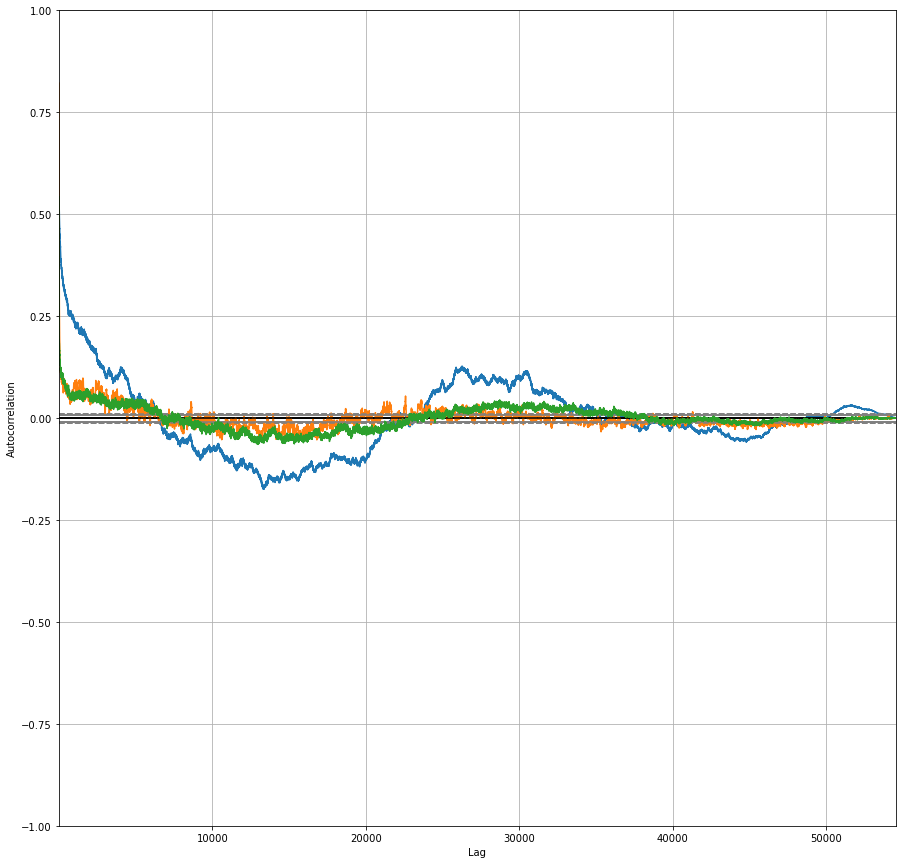

In [64]:
plt.figure(figsize=(15,15))
AC_plot(test_data[0])
AC_plot(test_data[1])
AC_plot(test_data[2])